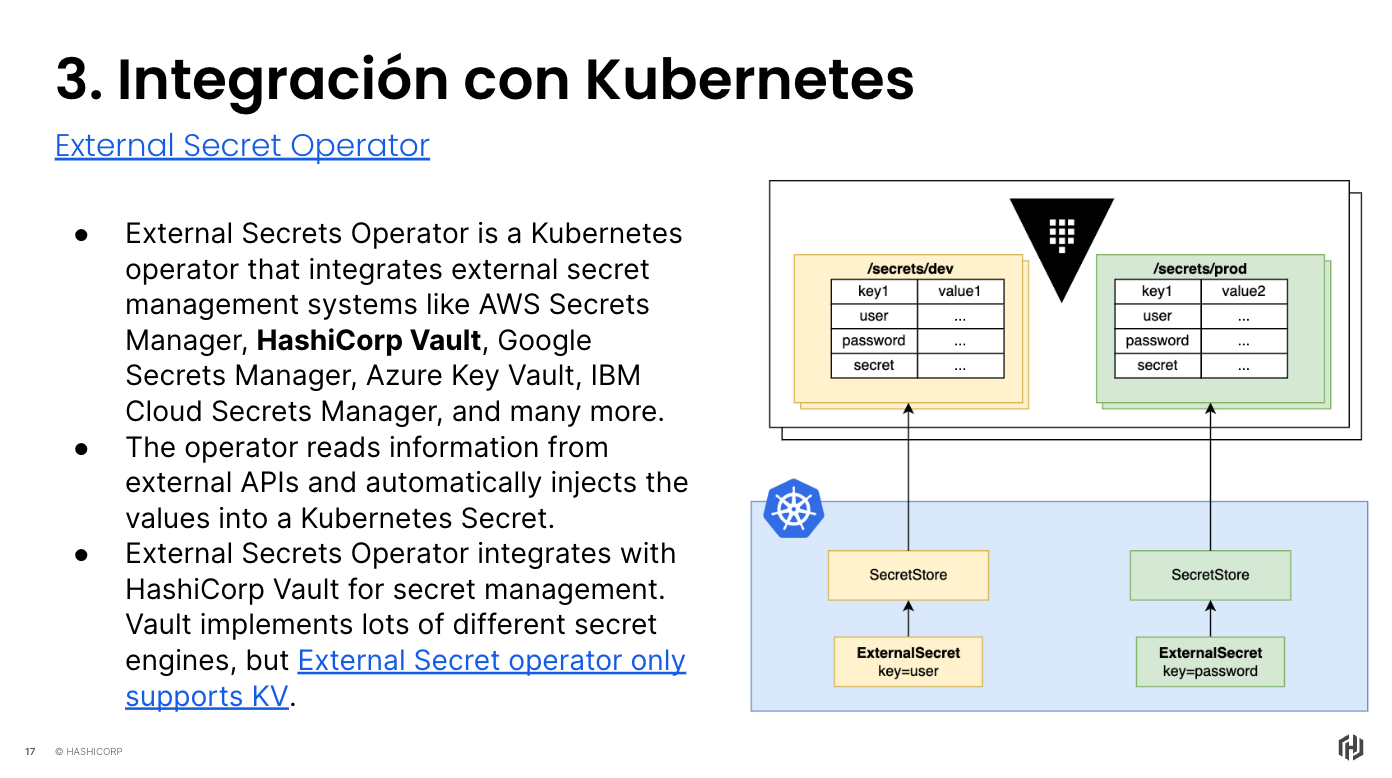

In [ ]:
%env WORKDIR=/tmp/vault
%env VAULT_K8S_NAMESPACE=vault
%env VAULT_HELM_RELEASE_NAME=vault
%env VAULT_SERVICE_NAME=vault-internal 
%env K8S_CLUSTER_NAME=cluster.local 

In [ ]:
%%bash
cat ${WORKDIR}/cluster-keys.json | jq -r ".root_token"

In [ ]:
%%bash
# https://external-secrets.io/v0.8.1/introduction/getting-started/
helm repo add external-secrets https://charts.external-secrets.io

helm install external-secrets \
   external-secrets/external-secrets \
    -n external-secrets \
    --create-namespace \
    --set installCRDs=true

In [ ]:
%%bash
helm ls -n external-secrets
kubectl get all -n external-secrets

### Autenticando usando token authentication (https://external-secrets.io/v0.5.2/provider-hashicorp-vault/#authentication)

In [ ]:
%%bash
# Integrating using token authentication.
# No need to enable token auth - enabled by default
kubectl create secret generic vault-token --from-literal="token=hvs.kABdKt9HrZusmhHhIbqQSB8W" -n vault

cat > ext_so_crd.yaml <<EOF
---
apiVersion: external-secrets.io/v1beta1
kind: SecretStore
metadata:
  name: vault-backendtoken
  namespace: vault
spec:
  provider:
    vault:
      server: "https://vault.vault:8200"
      path: "secret"
      version: "v2"
      caProvider:
        # Can be Secret or ConfigMap
        type: "Secret"
        name: "vault-ha-tls"
        key: "vault.ca"
      auth:
        # points to a secret that contains a vault token
        # https://www.vaultproject.io/docs/auth/token
        tokenSecretRef:
          name: "vault-token"
          key: "token"

EOF
kubectl apply -f ext_so_crd.yaml
kubectl get SecretStore -n vault

### Usando Kubernetes Authentication

In [ ]:
%%bash

## This time using Kubernetes Authentication
cat > ext_so_crd2.yaml <<EOF
---
apiVersion: external-secrets.io/v1beta1
kind: SecretStore
metadata:
  name: vault-backendk8s
  namespace: vault
spec:
  provider:
    vault:
      server: "https://vault.vault:8200"
      path: "secret"
      version: "v2"
      caProvider:
        # Can be Secret or ConfigMap
        type: "Secret"
        name: "vault-ha-tls"
        key: "vault.ca"
      auth:
        kubernetes:
          mountPath: "kubernetes"
          role: "example"
          serviceAccountRef:
            name: "default"

EOF
kubectl apply -f ext_so_crd2.yaml

kubectl get SecretStore -n vault

### Sincronizando secretos

In [ ]:
%%bash

cat > ext_secret1_crd.yaml <<EOF
---
apiVersion: external-secrets.io/v1beta1
kind: ExternalSecret
metadata:
  name: vault-exampletoken
  namespace: vault
spec:
  refreshInterval: "15s"
  secretStoreRef:
    name: vault-backendtoken #Aquí es donde definimos que secretStore se usa
    kind: SecretStore
  target:
    name: example-synctoken
  data:
  - secretKey: contact_email
    remoteRef:
      key: secret/ops/acme
      property: contact_email

EOF
kubectl apply -f ext_secret1_crd.yaml
kubectl describe ExternalSecret vault-exampletoken -n vault
sleep 3
echo '**************************'
kubectl get secret example-synctoken -n vault -o yaml

In [ ]:
%%bash

cat > ext_secret2_crd.yaml <<EOF
---
apiVersion: external-secrets.io/v1beta1
kind: ExternalSecret
metadata:
  name: vault-examplek8s
  namespace: vault
spec:
  refreshInterval: "15s"
  secretStoreRef:
    name: vault-backendk8s #Aquí es donde definimos que secretStore se usa
    kind: SecretStore
  target:
    name: example-synck8s
  data:
  - secretKey: contact_email
    remoteRef:
      key: secret/ops/acme
      property: contact_email

EOF
kubectl apply -f ext_secret2_crd.yaml
kubectl describe ExternalSecret vault-examplek8s -n vault
sleep 3
echo "**************************"
kubectl get secret example-synck8s -n vault -o yaml

## Consumiendo el secreto desde un POD

In [ ]:
%%bash
# Consuming secret using K8S Authentication
cat > mypod2_test.yaml <<EOF
apiVersion: v1
kind: Pod
metadata:
  name: mypod2
  namespace: vault
  # Using a different service account
spec:
  containers:
  - name: mypod
    image: redis
    volumeMounts:
    - name: foo
      mountPath: "/etc/foo"
      readOnly: true
  volumes:
  - name: foo
    secret:
      secretName: example-synck8s 
      optional: true
EOF

kubectl apply -f mypod2_test.yaml
sleep 10

In [ ]:
%%bash
kubectl exec mypod2 -n vault -- ls /etc/foo/
kubectl exec mypod2 -n vault -- cat /etc/foo/contact_email

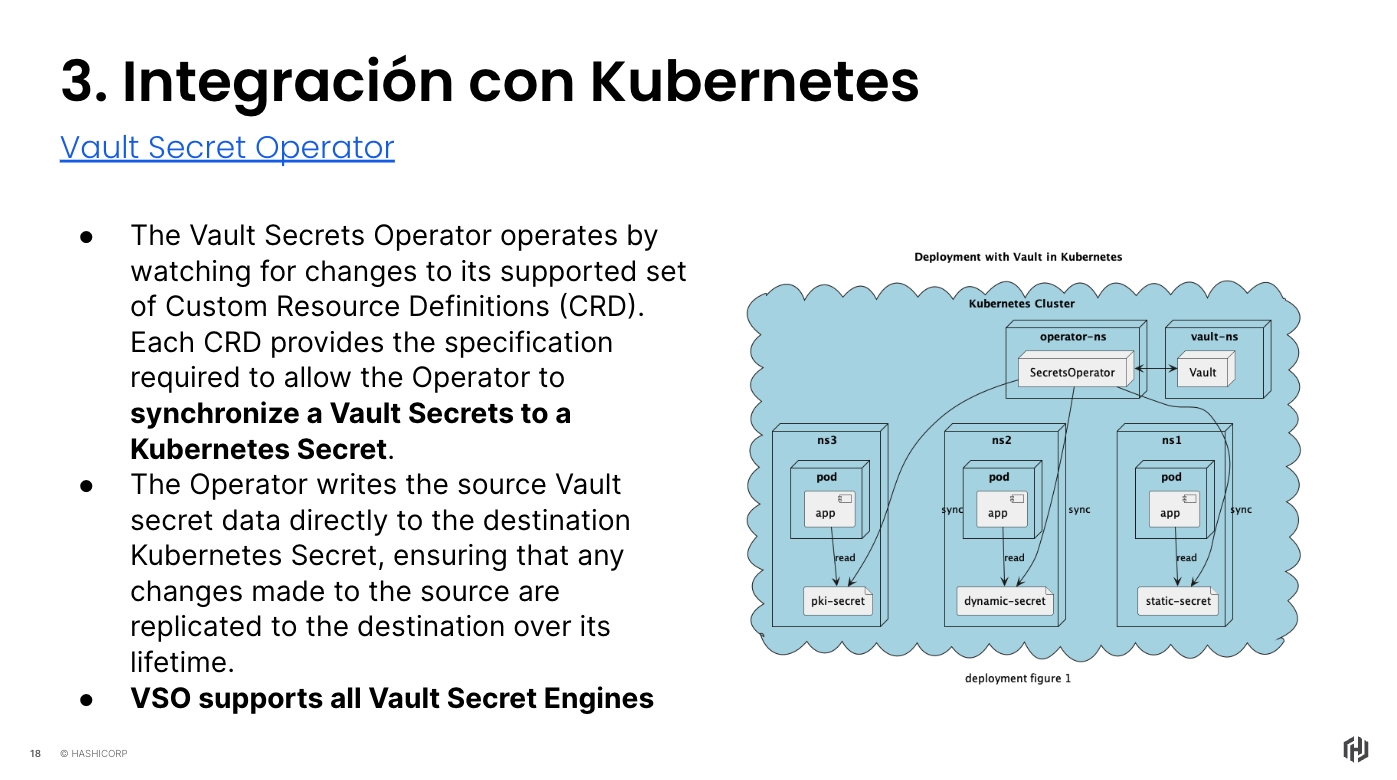

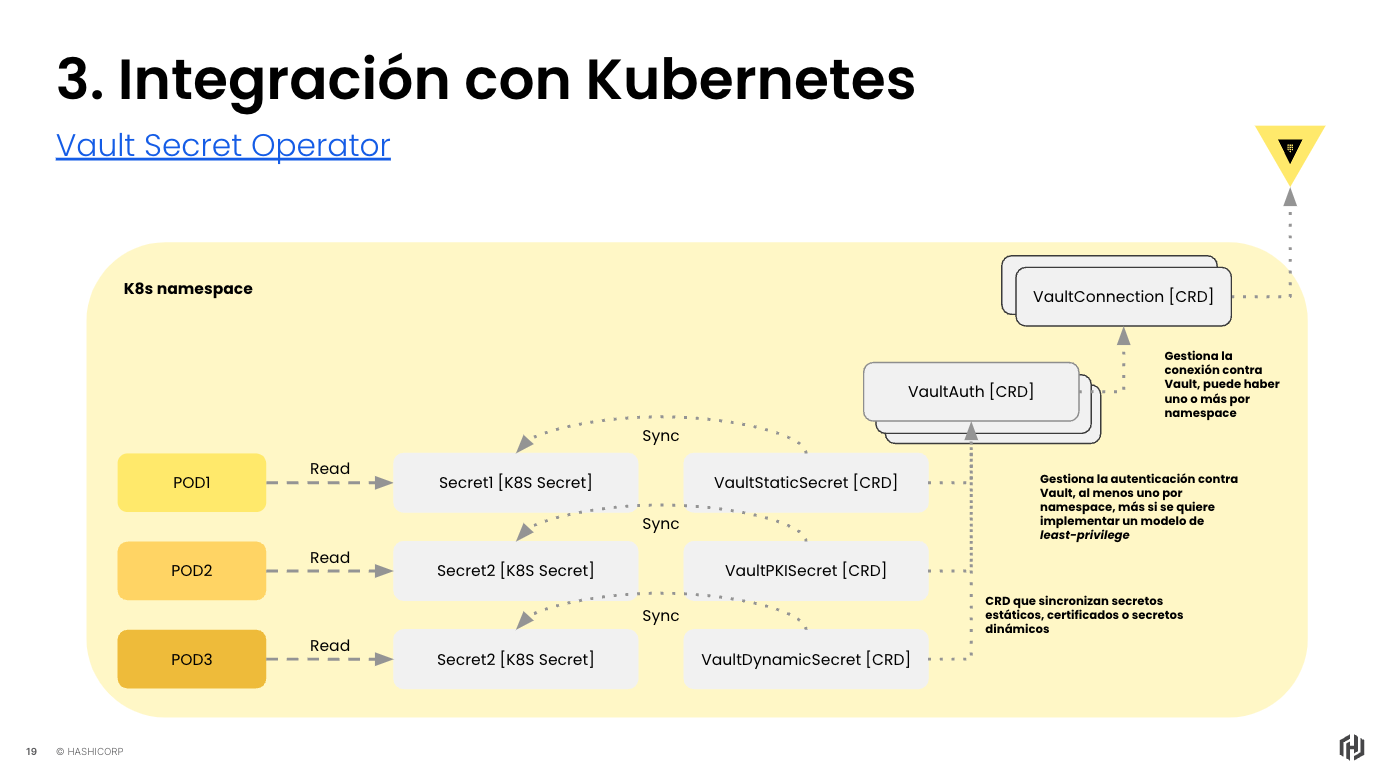

## Ahora usando Vault Secret Operator

In [ ]:
%%bash
cat ${WORKDIR}/cluster-keys.json | jq -r ".root_token"

In [ ]:
%env VAULT_ADDR=https://127.0.0.1:8200
%env VAULT_TOKEN=hvs.kABdKt9HrZusmhHhIbqQSB8W
%env VAULT_CACERT=/tmp/vault/vault.ca

In [ ]:
%%bash
# Role associated to default service account in the app namespace
vault write auth/kubernetes/role/role1 \
    bound_service_account_names=default \
    bound_service_account_namespaces=vault \
    policies=devk8s \
    ttl=24h


In [ ]:
%%bash
# Role associated to default service account in the app namespace
vault write auth/kubernetes/role/role2 \
    bound_service_account_names=default \
    bound_service_account_namespaces=default \
    policies=devk8s \
    ttl=24h

In [ ]:
%%bash
vault policy write devk8s - <<EOF
path "kvv2/*" {
  capabilities = ["read"]
}
EOF


In [ ]:
%%bash
vault secrets enable -path=kvv2 kv-v2

In [ ]:
%%bash
vault kv put kvv2/webapp/config username="static-user" password="static-password"

### Instalando el VSO usando helm

In [ ]:
%%bash
helm search repo hashicorp/vault-secrets-operator --devel
helm install --namespace $VAULT_K8S_NAMESPACE vault-secrets-operator hashicorp/vault-secrets-operator --version 0.1.0-beta


In [ ]:
%%bash
## VaultConnection Custom Resource
cat > vso_crd.yaml <<EOF
---
apiVersion: secrets.hashicorp.com/v1alpha1
kind: VaultConnection
metadata:
  namespace: vault
  name: example
spec:
  # required configuration
  # address to the Vault server.
  address: https://vault.vault.svc.cluster.local:8200

  # optional configuration
  # HTTP headers to be included in all Vault requests.
  # headers: []
  # TLS server name to use as the SNI host for TLS connections.
  # tlsServerName: ""
  # skip TLS verification for TLS connections to Vault.
  skipTLSVerify: true
  # the trusted PEM encoded CA certificate chain stored in a Kubernetes Secret
  # caCertSecretRef: ""

EOF
kubectl apply -f vso_crd.yaml
echo '---'
kubectl describe VaultConnection example -n vault


In [ ]:
%%bash
## Otro VaultConnection para otro namespace
## VaultConnection Custom Resource
cat > vso_crd_2.yaml <<EOF
---
apiVersion: secrets.hashicorp.com/v1alpha1
kind: VaultConnection
metadata:
  namespace: default
  name: example
spec:
  # required configuration
  # address to the Vault server.
  address: https://vault.vault.svc.cluster.local:8200

  # optional configuration
  # HTTP headers to be included in all Vault requests.
  # headers: []
  # TLS server name to use as the SNI host for TLS connections.
  # tlsServerName: ""
  # skip TLS verification for TLS connections to Vault.
  skipTLSVerify: true
  # the trusted PEM encoded CA certificate chain stored in a Kubernetes Secret
  # caCertSecretRef: ""

EOF
kubectl apply -f vso_crd_2.yaml
echo '---'
kubectl describe VaultConnection example

In [ ]:
%%bash
cat > vaultauth_crd.yaml <<EOF
---
apiVersion: secrets.hashicorp.com/v1alpha1
kind: VaultAuth
metadata:
  namespace: vault
  name: example
spec:
  # required configuration
  # VaultConnectionRef of the corresponding VaultConnection CustomResource.
  # If no value is specified the Operator will default to the `default` VaultConnection,
  # configured in its own Kubernetes namespace.
  vaultConnectionRef: example
  # Method to use when authenticating to Vault.
  method: kubernetes
  # Mount to use when authenticating to auth method.
  mount: kubernetes
  # Kubernetes specific auth configuration, requires that the Method be set to kubernetes.
  kubernetes:
    # role to use when authenticating to Vault
    role: role1
    # ServiceAccount to use when authenticating to Vault
    # it is recommended to always provide a unique serviceAccount per Pod/application
    serviceAccount: default

  # optional configuration
  # Vault namespace where the auth backend is mounted (requires Vault Enterprise)
  # namespace: ""
  # Params to use when authenticating to Vault
  # params: []
  # HTTP headers to be included in all Vault authentication requests.
  # headers: []
EOF
kubectl apply -f vaultauth_crd.yaml
echo '---'
kubectl describe VaultAuth example -n vault

In [ ]:
%%bash
cat > vaultauth_crd2.yaml <<EOF
---
apiVersion: secrets.hashicorp.com/v1alpha1
kind: VaultAuth
metadata:
  namespace: default
  name: example2
spec:
  # required configuration
  # VaultConnectionRef of the corresponding VaultConnection CustomResource.
  # If no value is specified the Operator will default to the `default` VaultConnection,
  # configured in its own Kubernetes namespace.
  vaultConnectionRef: example
  # Method to use when authenticating to Vault.
  method: kubernetes
  # Mount to use when authenticating to auth method.
  mount: kubernetes
  # Kubernetes specific auth configuration, requires that the Method be set to kubernetes.
  kubernetes:
    # role to use when authenticating to Vault
    role: role2
    # ServiceAccount to use when authenticating to Vault
    # it is recommended to always provide a unique serviceAccount per Pod/application
    serviceAccount: default

  # optional configuration
  # Vault namespace where the auth backend is mounted (requires Vault Enterprise)
  # namespace: ""
  # Params to use when authenticating to Vault
  # params: []
  # HTTP headers to be included in all Vault authentication requests.
  # headers: []
EOF
kubectl apply -f vaultauth_crd2.yaml
echo '---'
kubectl describe VaultAuth example

## CRD Static Secret

In [ ]:
%%bash
## Support KVv1 and KVv2
cat > static_secret.yaml <<EOF
---
apiVersion: secrets.hashicorp.com/v1alpha1
kind: VaultStaticSecret
metadata:
  namespace: vault
  name: example
spec:
  vaultAuthRef: example
  mount: kvv2
  type: kv-v2
  name: webapp/config
  refreshAfter: 60s
  destination:
    create: true
    name: static-secret1
EOF
kubectl apply -f static_secret.yaml
echo '---'
kubectl describe VaultStaticSecret example -n vault
echo '---'
sleep 5
kubectl get secret static-secret1 -n vault -o yaml


In [ ]:
%%bash
## Support KVv1 and KVv2
cat > static_secret.yaml <<EOF
---
apiVersion: secrets.hashicorp.com/v1alpha1
kind: VaultStaticSecret
metadata:
  namespace: default
  name: example
spec:
  vaultAuthRef: example2
  mount: kvv2
  type: kv-v2
  name: webapp/config
  refreshAfter: 60s
  destination:
    create: true
    name: static-secret1
EOF
kubectl apply -f static_secret.yaml
echo '---'
kubectl describe VaultStaticSecret example
echo '---'
sleep 5
kubectl get secret static-secret1 -o yaml

In [ ]:
%%bash
echo "namespace: Vault"
kubectl get secrets -n vault
echo "namespace: Default"
kubectl get secrets

In [ ]:
%%bash
cat > mypod.yaml <<EOF
apiVersion: v1
kind: Pod
metadata:
  name: mypod
  namespace: vault
spec:
  containers:
  - name: mypod
    image: nginx
    volumeMounts:
    - name: foo
      mountPath: "/etc/foo"
      readOnly: true
  volumes:
  - name: foo
    secret:
      secretName: static-secret1
      optional: true
EOF
kubectl apply -f mypod.yaml
sleep 10

# https://developer.hashicorp.com/vault/tutorials/kubernetes/vault-secrets-operator

In [ ]:
%%bash 
kubectl exec mypod -n vault -- ls /etc/foo
echo ""
echo "------"
kubectl exec mypod -n vault -- cat /etc/foo/_raw

### mostrando que la serviceaccount del Pod no influye (el acceso viene impersonado por Vault-Auth CRD)

In [ ]:
%%bash
cat > mypod3.yaml <<EOF
apiVersion: v1
kind: Pod
metadata:
  name: mypod3
  namespace: vault
  # Using a different service account
spec:
  serviceAccountName: vault
  containers:
  - name: mypod
    image: redis
    volumeMounts:
    - name: foo
      mountPath: "/etc/foo"
      readOnly: true
  volumes:
  - name: foo
    secret:
      secretName: static-secret1
      optional: true
EOF
kubectl apply -f mypod3.yaml

In [ ]:
%%bash 
sleep 10 
kubectl exec   mypod3 -n vault -- cat /etc/foo/username
echo ""
echo "------"
kubectl exec mypod3 -n vault -- cat /etc/foo/password

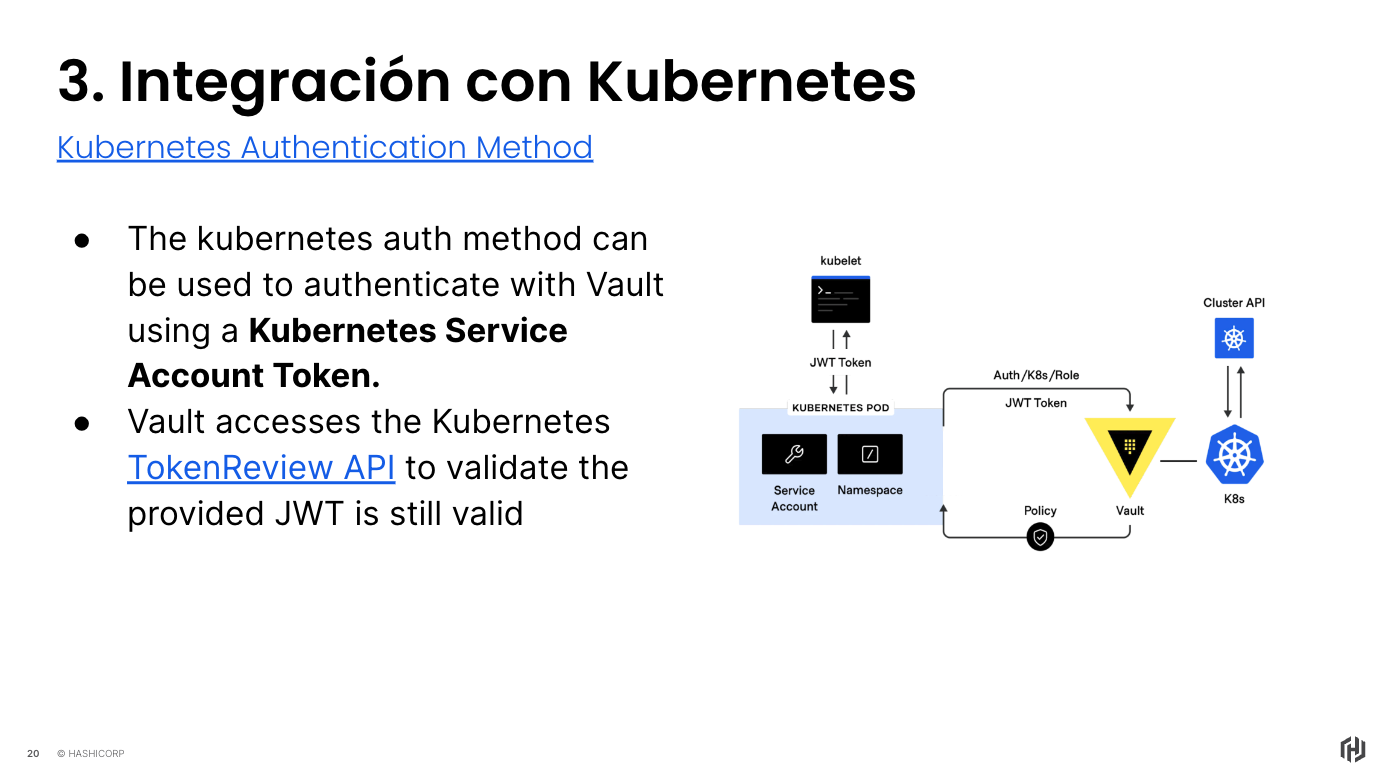

## ¿Cómo funciona la autenticación de Kubernetes?

## (Tras crear la dB engine) Dynamic Secrets

In [ ]:
%%bash

# Actualizar la políticas con permisos de lectura al path de la database
vault policy write devk8s - <<EOF
path "kvv2/*" {
  capabilities = ["read"]
}
path "database/creds/readonly" {
  capabilities = [ "read"]
}
EOF


cat > dynamic_secret.yaml <<EOF
---
apiVersion: secrets.hashicorp.com/v1alpha1
kind: VaultDynamicSecret
metadata:
  namespace: default
  name: exampled
spec:
  vaultAuthRef: example2
  mount: database
  role: readonly
  destination:
    create: true
    name: dynamic-secret1
EOF

kubectl apply -f dynamic_secret.yaml
echo '---'
sleep 3
kubectl describe VaultDynamicSecret exampled
echo '---'
sleep 5
kubectl get secret dynamic-secret1 -o yaml

In [ ]:
%%bash
cat > mypod_db.yaml <<EOF
apiVersion: v1
kind: Pod
metadata:
  name: mypoddb
  # Using a different service account
spec:
  containers:
  - name: mypod
    image: redis
    volumeMounts:
    - name: foo
      mountPath: "/etc/foo"
      readOnly: true
  volumes:
  - name: foo
    secret:
      secretName: dynamic-secret1
      optional: true
EOF


# Despliega el POD
kubectl apply -f mypod_db.yaml
# Espera a que despliegue
sleep 10 
# Chequea secretos
kubectl exec mypoddb  -- ls /etc/foo/
echo ""
echo "------"
kubectl exec mypoddb -- cat /etc/foo/_raw

## Tras crear la LDAP engine

In [ ]:
%%bash 

# Actualizar la políticas con permisos de lectura al path de la ldap engine
vault policy write devk8s - <<EOF
path "kvv2/*" {
  capabilities = ["read"]
}
path "database/creds/readonly" {
  capabilities = [ "read"]
}
path "ldap/creds/dynamic" {
  capabilities = [ "read"]
}
EOF

cat > dynamic_secret2.yaml <<EOF
---
apiVersion: secrets.hashicorp.com/v1alpha1
kind: VaultDynamicSecret
metadata:
  namespace: default
  name: exampled2
spec:
  vaultAuthRef: example2
  mount: ldap
  role: dynamic
  destination:
    create: true
    name: dynamic-secret2
EOF

kubectl apply -f dynamic_secret2.yaml
echo '---'
sleep 3
kubectl describe VaultDynamicSecret exampled2
echo '---'
sleep 5
kubectl get secret dynamic-secret2 -o yaml

In [ ]:
%%bash
cat > mypod_ldap.yaml <<EOF
apiVersion: v1
kind: Pod
metadata:
  name: mypodldap
  # Using a different service account
spec:
  containers:
  - name: mypod
    image: redis
    volumeMounts:
    - name: foo
      mountPath: "/etc/foo"
      readOnly: true
  volumes:
  - name: foo
    secret:
      secretName: dynamic-secret2
      optional: true
EOF
kubectl apply -f mypod_ldap.yaml

In [ ]:
%%bash 
sleep 10 
kubectl exec mypodldap  -- ls /etc/foo/
echo ""
echo "------"
kubectl exec mypodldap -- cat /etc/foo/_raw